In [1]:
import pandas as pd
import os
import json
import numpy as np

# Create Reference Dataset

We evaluate our computed difficulty by comparing it with a known standard.
This standard is derived from the "Complex Word Identification Shared Task 2018" Dataset https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip

We start of by loading the files into a dataframe.

In [2]:
headers=["sentence_id", "sentence", "phrase_start", "phrase_end", 'phrase', 'num_native_annotator', "num_non_native_annotator", "num_complex_marks_native", "num_complex_marks_non_native", "complex_binary", "complex_prob"]

datasets=["../src/data/cwishareddataset/traindevset/english/Wikipedia_Dev.tsv","../src/data/cwishareddataset/traindevset/english/Wikipedia_Train.tsv", "../src/data/cwishareddataset/testset/english/Wikipedia_Test.tsv"]
dataset_names = ['Wikipedia_dev', "Wikipedia_train", "Wikipedia_test"]

data = pd.read_csv(os.path.abspath(datasets[0]), sep='\t', names=headers)

## Extracting relevant information

We are interested in the assigned difficulties for each word and all the unique sentences used in the dataset.

We discard all phrases which are concatenated out of multiple words, because we do not handle phrases in our pipeline.

In [3]:
def count_words(row):
    """
    Count words per phrase
    """
    phrase = row['phrase']
    return len(phrase.split())

def get_words(data):
    """
    Cleanes up the dataframe and discards unused words
    """
    data["complex_prob_str"] = data.apply(lambda row: format(row['complex_prob'], ".2f"), axis=1 )
    data['num_words'] = data.apply(lambda row: count_words(row), axis=1)
    words = data[data['num_words']==1]
    words['phrase'].str.lower()
    words['phrase'].str.strip()
    words = words.rename(columns={'complex_prob': 'reference_difficulty'})
    words = words.groupby('phrase')['reference_difficulty'].apply(max).reset_index()
    return words

def get_sentences(data):
    """
    Returns all unique sentences
    """
    return data['sentence'].unique()
    
words = get_words(data)
words[['phrase', 'reference_difficulty']].sort_values(['reference_difficulty'], ascending=False)

sentences = get_sentences(data)



In [4]:
words.head(10)

,phrase,reference_difficulty
0,pharmacies,0.00
1,A0,0.00
2,A9,0.00
3,AGL,0.00
4,AMPAS,0.00
5,Above,0.00
6,Academy,0.00
7,According,0.05
8,Acherontia,0.10
9,Adi,0.00


In [5]:
sentences[:10]

array(['The tail of Epidexipteryx also bore unusual vertebrae towards the tip which resembled the feather-anchoring pygostyle of modern birds and some oviraptorosaurs .',
       'Epidexipteryx also preserved a covering of simpler body feathers , composed of parallel barbs as in more primitive feathered dinosaurs .',
       'However , unlike in modern-style rectrices ( tail feathers ) , the vanes were not branched into individual filaments but made up of a single ribbon-like sheet .',
       'It has been reported to be a maniraptoran dinosaur from the Middle Jurassic or Upper Jurassic age Daohugou Beds of Inner Mongolia , China ( about 160 or 168 mya ) .',
       "Epidexipteryx ( `` display feather '' ) is a genus of small paravian dinosaur , known from one fossil specimen in the collection of the Institute of Vertebrate Paleontology and Paleoanthropology in Beijing .",
       'Medicine recognizes that altitudes above 1,500 metres ( 4,900 ft ) start to affect humans , and there is no re

In [6]:
def get_text_and_metadata(data):
    """
    Bundles the sentence and word function calls
    and returns a text which is created by concatenating 
    the individual sentences and a dataframe containing all words
    and their difficulty
    """

    sentences = get_sentences(data)
    words = get_words(data)
    
    text = " ".join(sentences.tolist())

    phrases = words['phrase'].to_list()
    weights = words['reference_difficulty'].to_list()
    

    word_weights = words[['phrase', 'reference_difficulty']]
    
    return text, word_weights



## Creating multiple datasets

The following block creates these datasets for each
input csv and stores them in the texts and wordsets lists
as well as in the filesystem.

In [7]:
directory = "../src/data/evaluation/" 

if not os.path.exists(directory):
    os.makedirs(directory)

texts, wordsets = [],[]
    
for name, dataset in zip(dataset_names, datasets):
    data = pd.read_csv(dataset, sep='\t', names=headers)
    text, wordset = get_text_and_metadata(data)

    texts.append(text)
    wordsets.append(wordset)
    
    with open(directory+name+".txt", "w")as f:
        f.write(text)
        
    wordset.to_csv(path_or_buf=directory+name+".csv")


# Evaluation

We evaluate our pipeline by passing it one of our generated texts 
and correlating the output with the data stored in the matching wordset list.

This is implemented in the ```evaluate_ranking```-function which returns a dataframe which merges the wordset with the inputed dataframe and two singular values characterizing the performance of the pipeline.

In [8]:
from vocabulary_extraction.utils.output_utils.create_df_from_doc import create_df_from_doc
from vocabulary_extraction.pipeline.create_pipeline import create_pipeline

pipeline = create_pipeline()
doc = pipeline(texts[0])
df = create_df_from_doc(doc)
df.sort_values(by="relative frequency").head(10)

,token,lemma,appearance,difficulty,relative frequency,keyword score,example phrase,overall_ranking
218,number,number,1,0.343,0.000006,0.747592,"During the 2000s , Romania implemented a numbe...",1.776599
116,set,set,1,0.322,0.000006,0.911400,The zero point of any thermodynamic temperatur...,1.877406
275,based,base,1,0.381,0.000006,0.000000,Their strongest emissions are in the infrared ...,1.143006
166,use,use,1,0.298,0.000006,0.000000,While some users can use them to circumvent ce...,0.894006
35,small,small,1,0.332,0.000006,0.911400,Epidexipteryx ( `` display feather '' ) is a g...,1.907406
164,table,table,1,0.401,0.000006,0.751565,Main-sequence stars vary in surface temperatur...,1.954572
115,scale,scale,1,0.406,0.000013,0.913094,The zero point of any thermodynamic temperatur...,2.131107
289,theory,theory,1,0.446,0.000013,0.751565,"In theory , a brown dwarf below 65 Jupiter mas...",2.089578
317,effects,effect,1,0.409,0.000013,0.000000,Devotion ( Bhakti ) will cancel the effects of...,1.227013
283,light,light,1,0.351,0.000013,0.751565,"However , such objects were hard to find becau...",1.804578


In [9]:
from vocabulary_extraction.utils.evaluation_utils.evaluation import evaluate_ranking

df_res, correlation, drop = evaluate_ranking(wordsets[0], df)
df_res.sort_values(by='overall_ranking', axis=0, ascending=False, na_position="last").head(30)

,phrase,reference_difficulty,token,lemma,appearance,difficulty,relative frequency,keyword score,example phrase,overall_ranking,ranking_error
373,paravian,0.45,paravian,paravian,1.0,0.889,1.000000,0.911400,Epidexipteryx ( `` display feather '' ) is a g...,4.578400,0.19755
396,pygostyle,0.85,pygostyle,pygostyle,1.0,0.889,1.000000,0.911400,The tail of Epidexipteryx also bore unusual ve...,4.578400,0.03315
335,maniraptoran,0.60,maniraptoran,maniraptoran,1.0,0.889,1.000000,0.911400,It has been reported to be a maniraptoran dino...,4.578400,0.17340
483,turīya,0.30,turīya,turīya,1.0,0.889,1.000000,0.747592,"Perceptible feeling - many people , when they ...",4.414592,0.17670
320,librettist,0.90,librettist,librettist,1.0,0.765,1.000000,0.911400,The Festival was founded in 1948 by the compos...,4.206400,0.12150
115,Perceptible,0.75,Perceptible,perceptible,1.0,0.699,1.000000,0.858240,"Perceptible feeling - many people , when they ...",3.955240,0.03825
490,unmolested,0.85,unmolested,unmolested,1.0,0.738,0.750002,0.747592,It is able to move about in hives unmolested b...,3.711594,0.09520
405,rectrices,0.50,rectrices,rectrix,1.0,0.889,1.000000,0.000000,"However , unlike in modern-style rectrices ( t...",3.667000,0.19450
370,oviraptorosaurs,0.75,oviraptorosaurs,oviraptorosaur,1.0,0.889,1.000000,0.000000,The tail of Epidexipteryx also bore unusual ve...,3.667000,0.10425
47,Devotion,0.45,Devotion,devotion,1.0,0.568,1.000000,0.860182,Devotion ( Bhakti ) will cancel the effects of...,3.564182,0.05310


## Interpreting the results

Using the get_difficulty_scatter()-function we can plot the reference difficulty vs. the computed difficulty for each word.

Correlation is the computed pearson correlation for these value pairs

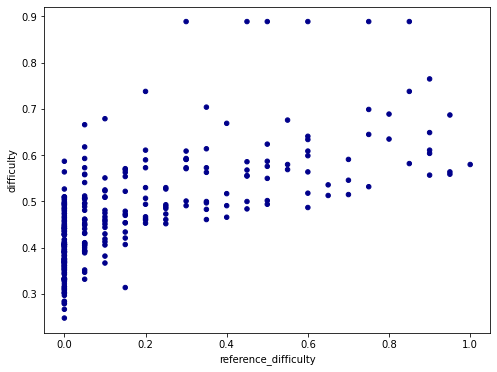

In [10]:
from vocabulary_extraction.utils.evaluation_utils.evaluation import get_difficulty_scatter

get_difficulty_scatter(df_res)

In [11]:
correlation

0.6834136968100372

The get_dropped_histogram-function shows how many words per difficulty bucket where omitted by our pipeline.

drop is the mean difficulty of all dropped words.

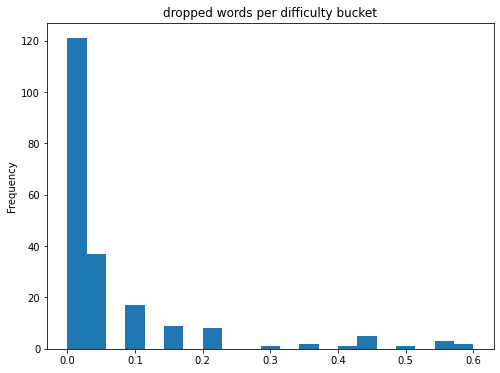

In [12]:
from vocabulary_extraction.utils.evaluation_utils.evaluation import get_dropped_histogram

get_dropped_histogram(df_res)

In [13]:
drop

0.02014492753623189